<a href="https://colab.research.google.com/github/KrsNovita2717/FaceExpressionDetection/blob/main/FaceExpressionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import library yang dibutuhkan
import cv2
import numpy as np
import os
import zipfile
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
# Ekstraksi dataset
"""
# Menggunakan dataset yang tersimpan di google drive
from google.colab import drive
drive.mount('/content/drive')
local_zip = '/content/drive/MyDrive/FER/FER.zip'
"""
# Menggunakan API Kaggle

#Upload kunci API Kaggle
uploaded = files.upload()

# Pindahkan file ke direktori Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Unduh dataset dari Kaggle
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

local_zip = '/content/face-expression-recognition-dataset.zip'


zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/FER')
zip_ref.close()

Saving kaggle.json to kaggle (1).json
face-expression-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Fungsi untuk memuat data
def load_data(path):
    x = []
    y = []
    labels = []
    folderList = os.listdir(path)
    folderList.sort()

    for i, category in enumerate(folderList):
        files = os.listdir(os.path.join(path, category))
        for file in files:
            img = cv2.imread(os.path.join(path, category, file), 0)
            x.append(img)
            y.append(i)
            labels.append(category)
    labels = np.array(labels)
    return np.array(x, 'float32') / 255.0, to_categorical(np.array(y), num_classes=7), labels

In [ ]:
base_dir = '/content/FER/images'

train_dir = os.path.join(base_dir, 'images/train')
valid_dir = os.path.join(base_dir, 'images/validation')

# Memuat data train
x_train, y_train, train_labels = load_data(train_dir)
print("Jumlah data train:", len(x_train))

# Memuat data validation
x_valid, y_valid, valid_labels = load_data(valid_dir)
print("Jumlah data validation:", len(x_valid))

Jumlah data train: 28821
Jumlah data validation: 7066


In [ ]:
# Reshape data train dan validation
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_valid = x_valid.reshape(x_valid.shape[0], 48, 48, 1)

In [ ]:
# Augmentasi gambar
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_datagen.fit(x_train)

In [ ]:
# Membangun model CNN
model = Sequential([
    Conv2D(64, (3,3), padding="same", activation="relu", input_shape=(48, 48, 1)),
    Conv2D(64, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), padding="same", activation="relu"),
    Conv2D(128, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.25),

    Conv2D(256, (3,3), padding="same", activation="relu"),
    Conv2D(256, (3,3), padding="same", activation="relu"),
    Conv2D(256, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.25),

    Conv2D(512, (3,3), padding="same", activation="relu"),
    Conv2D(512, (3,3), padding="same", activation="relu"),
    Conv2D(512, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.25),

    Conv2D(512, (3,3), padding="same", activation="relu"),
    Conv2D(512, (3,3), padding="same", activation="relu"),
    Conv2D(512, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(4096, activation="relu"),
    Dropout(0.5),
    Dense(4096, activation="relu"),
    Dense(7, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       147584    
                                                        

In [ ]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
# Latih model
batch_size = 32
epochs = 100

stopEarly = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=5)

history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks=[stopEarly]
)

Epoch 1/100
900/900 [==============================] - 61s 57ms/step - loss: 1.8195 - accuracy: 0.2460 - val_loss: 1.8147 - val_accuracy: 0.2583
Epoch 2/100
900/900 [==============================] - 49s 55ms/step - loss: 1.8123 - accuracy: 0.2485 - val_loss: 1.8024 - val_accuracy: 0.2583
Epoch 3/100
900/900 [==============================] - 49s 55ms/step - loss: 1.7996 - accuracy: 0.2491 - val_loss: 1.7992 - val_accuracy: 0.2637
Epoch 4/100
900/900 [==============================] - 47s 52ms/step - loss: 1.7892 - accuracy: 0.2509 - val_loss: 1.7733 - val_accuracy: 0.2491
Epoch 5/100
900/900 [==============================] - 47s 52ms/step - loss: 1.7795 - accuracy: 0.2571 - val_loss: 1.7443 - val_accuracy: 0.2975
Epoch 6/100
900/900 [==============================] - 50s 56ms/step - loss: 1.7381 - accuracy: 0.2833 - val_loss: 1.6817 - val_accuracy: 0.3176
Epoch 7/100
900/900 [==============================] - 50s 56ms/step - loss: 1.6961 - accuracy: 0.3036 - val_loss: 1.6684 - val_ac

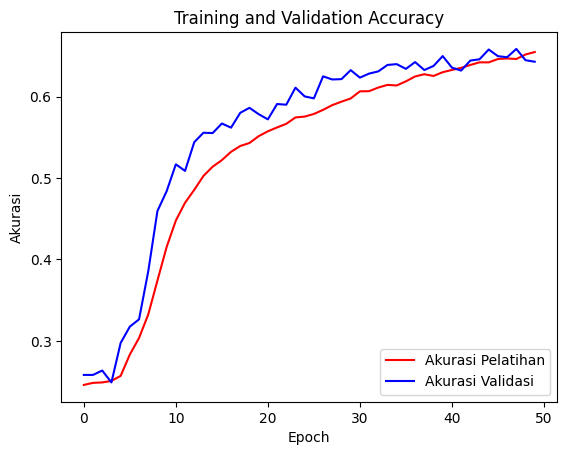

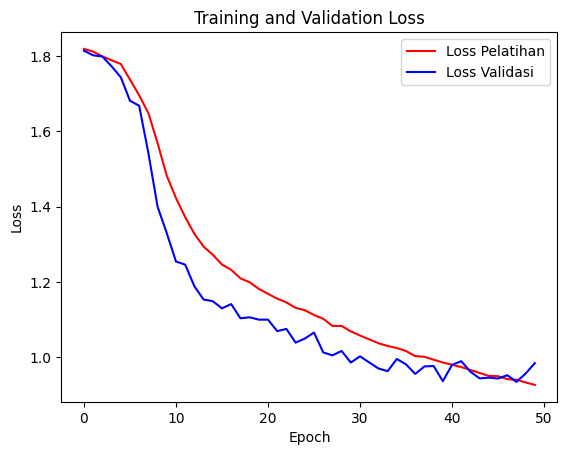

In [ ]:
# Tampilkan grafik akurasi dan loss
plt.plot(history.history['accuracy'], 'r', label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], 'b', label='Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.title("Training and Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], 'r', label='Loss Pelatihan')
plt.plot(history.history['val_loss'], 'b', label='Loss Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training and Validation Loss")
plt.legend(loc='upper right')
plt.show()

Saving test2.jpg to test2.jpg
1/1 [==============================] - 0s 26ms/step
Hasil prediksi: surprise


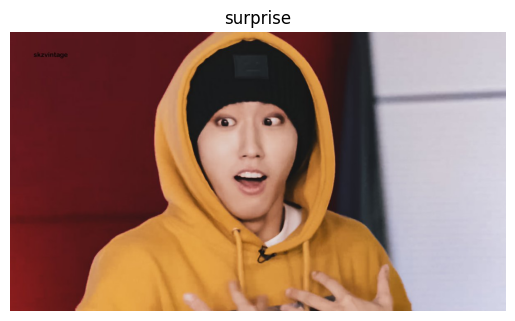

In [ ]:
# Dictionary korespondensi label kelas dan nama folder
label_to_class = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Upload gambar untuk pengujian
uploaded = files.upload()

for filename in uploaded.keys():
    path = '/content/' + filename
    img = cv2.imread(path, 0)
    img = cv2.resize(img, (48, 48))
    img = np.array(img, 'float32') / 255.0
    img = img.reshape(1, 48, 48, 1)
    prediction = model.predict(img)
    label = np.argmax(prediction)
    predicted_class = label_to_class[label]
    print("Hasil prediksi:", predicted_class)

    # Tampilkan gambar
    plt.imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))  # Konversi ke format RGB
    plt.title(predicted_class)  # Judul gambar sesuai dengan hasil prediksi
    plt.axis('off')  # Hilangkan sumbu x dan y
    plt.show()


In [ ]:
from google.colab import drive
model.save("FaceExpressionDetection.h5")
!ls
files.download('FaceExpressionDetection.h5')